In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/SANIA


In [8]:
%load_ext autoreload
%autoreload 2

import os
import sys
import urllib.request

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, RandomSampler
import torch.optim as optim

import torchvision
import torchvision.models as models
from torchvision.transforms import v2

from sklearn.datasets import load_svmlight_file

import matplotlib.pyplot as plt

import experiments.loss_functions as lf
from experiments.utils import load_results, save_results
from experiments.utils import get_MNIST, get_CIFAR10, get_FashionMNIST, get_CIFAR100

from SANIA import SANIA_AdagradSQR, SANIA_AdamSQR, KATE

import experiments.cifar_resnet as cifar_resnet

from datasets import load_dataset, DatasetDict
import tiktoken, numpy as np, torch


from dotenv import load_dotenv
load_dotenv()

torch.set_default_dtype(torch.float64)
torch.set_num_threads(2)    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
from vit_pytorch import ViT

vit_model = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)


d = np.sum([w.numel() for w in vit_model.parameters()])
print(f"Total parameters: {d:,}") 

img = torch.randn(1, 3, 256, 256)
preds = vit_model(img) # (1, 1000)

Total parameters: 54,630,376


In [12]:
from datasets import load_dataset

ds = load_dataset("ethz/food101")

ds

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [ ]:

ds = load_dataset("Ankursingh/openwebtext_10K")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 10000
    })
    val: Dataset({
        features: ['text'],
        num_rows: 4007
    })
})

In [7]:
from datasets import load_dataset

ds = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")

ds

README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [23]:
IGNORE_INDEX = -100
BLOCK_SIZE   = 256  # try 128–256 for quick tests; must be <= model.config.sequence_length
BATCH_SIZE   = 32



In [24]:
enc = tiktoken.get_encoding('gpt2')

def tok_fn(batch):
    # returns list[list[int]] under 'input_ids'
    ids = [enc.encode(t) for t in batch["text"]]
    return {"input_ids": ids}

tok = ds.map(tok_fn, batched=True, remove_columns=ds["train"].column_names)

def pack_and_chunk(examples):
    # 1) flatten all token lists from this batch into one long array
    flat = np.array([t for seq in examples["input_ids"] for t in seq], dtype=np.int64)
    # 2) drop remainder so length is a multiple of BLOCK_SIZE
    L = (len(flat) // BLOCK_SIZE) * BLOCK_SIZE
    flat = flat[:L]
    if L == 0:
        return {"input_ids": [], "labels": []}
    # 3) reshape to [num_chunks, BLOCK_SIZE]
    input_ids = flat.reshape(-1, BLOCK_SIZE)
    # 4) labels = next-token shift; last token is ignore_index
    labels = input_ids.copy()
    labels[:, :-1] = input_ids[:, 1:]
    labels[:, -1]  = IGNORE_INDEX
    return {"input_ids": input_ids, "labels": labels}

lm_train = tok["train"].map(pack_and_chunk, batched=True, batch_size=1000)
lm_val   = tok["validation"].map(pack_and_chunk, batched=True, batch_size=1000)
# lm_val   = tok["val"].map(pack_and_chunk, batched=True, batch_size=1000)

# set tensor format for PyTorch
cols = ["input_ids", "labels"]
lm_train = lm_train.with_format("torch", columns=cols)
lm_val   = lm_val.with_format("torch", columns=cols)

len(lm_train), len(lm_val), lm_train[0]["input_ids"][:10], lm_train[0]["labels"][:10]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

(459722,
 964,
 tensor([  796,   569, 18354,  7496, 17740,  6711,   796,   220,   198,  2311]),
 tensor([  569, 18354,  7496, 17740,  6711,   796,   220,   198,  2311,    73]))

In [25]:
train_dl = DataLoader(lm_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl   = DataLoader(lm_val,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)



In [26]:
from experiments.llm_baselines.src.models.base import GPTBase

class Cfg: pass
cfg = Cfg()
cfg.vocab_size      = enc.n_vocab         # 50257
cfg.sequence_length = BLOCK_SIZE          # must be >= BLOCK_SIZE
cfg.n_layer = 2
cfg.n_head  = 2
cfg.n_embd  = 128
cfg.dropout = 0.0
cfg.bias    = False

from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model
model = AutoModelForCausalLM.from_pretrained("erwanf/gpt2-mini").to(device)

no_decay = ["bias", "LayerNorm.weight"]
decay, no = [], []
for n, p in model.named_parameters():
    if not p.requires_grad: 
        continue
    (no if any(nd in n for nd in no_decay) else decay).append(p)

optimizer = torch.optim.AdamW([
    {"params": decay, "weight_decay": 0.01},
    {"params": no,    "weight_decay": 0.0},
], lr=3e-4, betas=(0.9, 0.95), eps=1e-8)


# model = GPTBase(cfg).to(device)

# # AdamW baseline optimizer using your model's decay grouping
# name_groups = model.get_parameter_group_specs()
# param_dict  = {n: p for n, p in model.named_parameters()}
# optim_groups = [{"params": [param_dict[n] for n in g["params"]], **{k:v for k,v in g.items() if k!="params"}}
#                 for g in name_groups]
# optimizer = torch.optim.AdamW(optim_groups, lr=3e-4, betas=(0.9,0.95), eps=1e-8)


In [27]:
torch.manual_seed(1337)
model.train()

def run_epoch(dl, train=True):
    total, steps = 0.0, 0
    if not train: model.eval()
    for batch in dl:
        x = batch["input_ids"].to(device)
        y = batch["labels"].to(device)
        with torch.set_grad_enabled(train):
            out  = model(input_ids=x, labels=y)
            loss = out.loss
            if train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # optional
                optimizer.step()
        total += loss.item(); steps += 1
        if train and steps % 50 == 0:
            print(f"step {steps:4d}  train_loss {loss.item():.4f}")
        if steps == 200:  # keep it short for a smoke test
            break
    return total / max(1, steps)

for epoch in range(1, 4):
    tr = run_epoch(train_dl, train=True)
    va = run_epoch(val_dl,   train=False)
    print(f"epoch {epoch}  avg_train_loss {tr:.4f}  avg_val_loss {va:.4f}")

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


KeyboardInterrupt: 

In [39]:
model.eval()
with torch.no_grad():
    print(model.generate_from_string("The meaning of life", max_new_tokens=50, temperature=0.9))


The meaning of life of were sentence, but a most of terms ofrest lift over, they are the interest of the pieces of the project in there that gives that they was run, called if you have not = U. The say. I have would be have grounded


In [4]:
torch.manual_seed(0)

TORCHVISION_DATASETS_DIR = os.getenv("TORCHVISION_DATASETS_DIR")

# train_transforms = v2.Compose([
#     v2.RandomResizedCrop(size=(32, 32), antialias=True),
#     # v2.RandomHorizontalFlip(p=0.5),
#     # v2.RandomRotation(10),
#     v2.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#     v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     v2.ToImage(),
#     v2.ToDtype(torch.get_default_dtype(), scale=True),
#     v2.Normalize(
#         (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761),
#     ),
# ])

# test_transforms = v2.Compose([
#     v2.Resize(size=(32, 32)),
#     v2.CenterCrop((32, 32)),
#     v2.ToImage(),
#     v2.ToDtype(torch.get_default_dtype(), scale=True),
#     v2.Normalize(
#         (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761),
#     ),
# ])

train_transforms = v2.Compose([
        v2.RandomResizedCrop(size=(32, 32), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(10),
        v2.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        v2.ToImage(),
        v2.ToDtype(torch.get_default_dtype(), scale=True),
        v2.Normalize(
            (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261),
        ),
    ])

test_transforms = v2.Compose([
    v2.Resize(size=(32, 32)),
    v2.CenterCrop((32, 32)),
    v2.ToImage(),
    v2.ToDtype(torch.get_default_dtype(), scale=True),
    v2.Normalize(
        (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261),
    ),
])

# train_data = torchvision.datasets.SVHN(
#     TORCHVISION_DATASETS_DIR, split="train", download=True, transform=train_transforms
#     )
# test_data = torchvision.datasets.SVHN(
#     TORCHVISION_DATASETS_DIR, split="test", download=True, transform=test_transforms
#     )

train_data = torchvision.datasets.CIFAR10(
        TORCHVISION_DATASETS_DIR, train=True, download=True, transform=train_transforms
        )
test_data = torchvision.datasets.CIFAR10(
    TORCHVISION_DATASETS_DIR, train=False, download=True, transform=test_transforms
    )

train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=1024, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


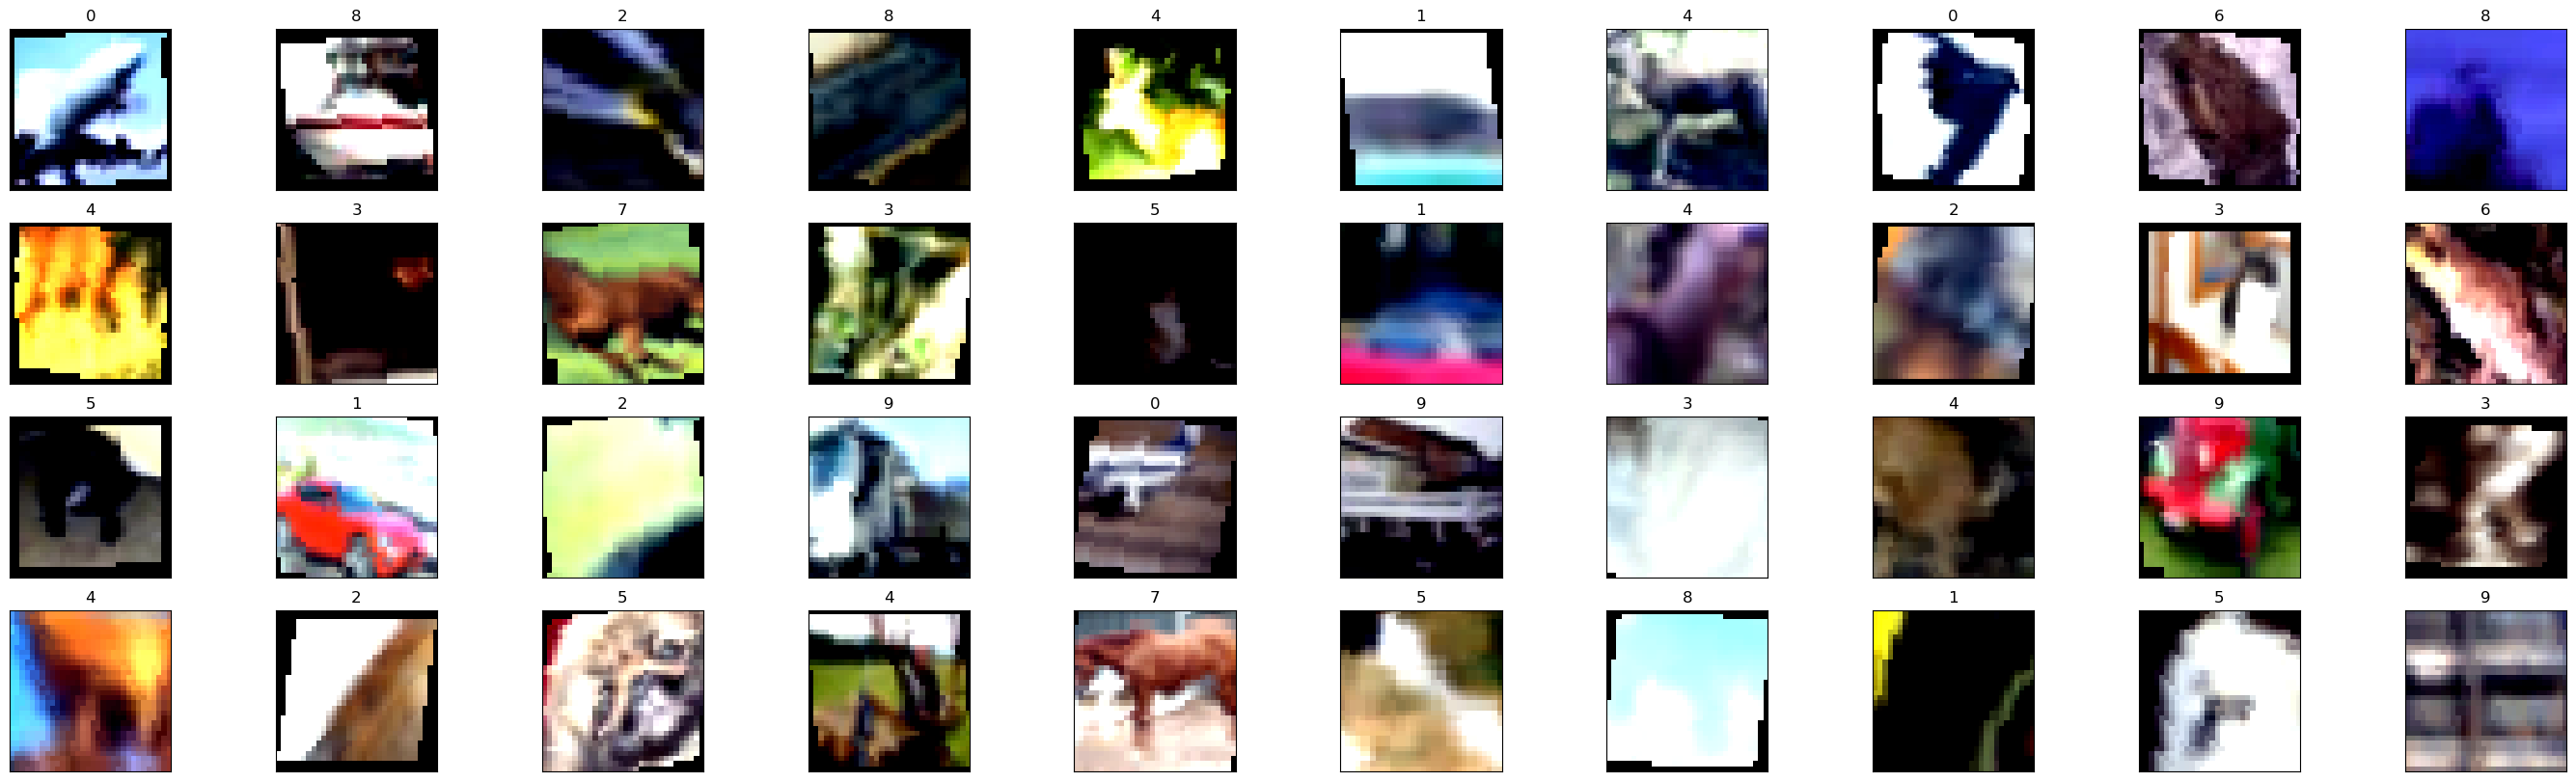

In [5]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image    

fig = plt.figure(figsize=(35, 10)) 

for idx, sample in enumerate(RandomSampler(train_data, num_samples=40)):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[]) 
    plt.imshow(im_convert(train_data[sample][0])) 
    ax.set_title(train_data[sample][1])

torch.Size([3, 32, 32])
tensor(1.6939) tensor(-0.6289)


AttributeError: 'CIFAR10' object has no attribute 'labels'

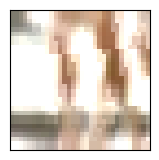

In [6]:
torch.manual_seed(0)

# TRAIN
# We iter the batch of images to display
dataiter = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = next(dataiter) #going from 1st batch of 100 images to the next batch
print(images[0].shape)
print(images[0].max(), images[0].min())
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(train_loader.dataset.labels[labels[idx].item()])
    
    
# TEST
# We iter the batch of images to display
dataiter = iter(test_loader) # converting our test_dataloader to iterable so that we can iter through it. 
images, labels = next(dataiter) #going from 1st batch of 100 images to the next batch
print(images[0].shape)
print(images[0].max(), images[0].min())
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our test_dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
    plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
    ax.set_title(test_loader.dataset.labels[labels[idx].item()])


In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes: int = 2):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        return y
    
class LeNet5X(nn.Module):
    def __init__(self, num_classes: int = 2):
        super(LeNet5X, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(400, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(128, 84)
        self.relu5 = nn.ReLU()
        self.fc4 = nn.Linear(84, num_classes)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        y = self.fc4(y)
        return y
    
    
class FashionSimpleNet(nn.Module):

    """ Simple network"""

    def __init__(self, num_classes: int = 2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=3, padding=1), # 28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 7
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 64 * 7 * 7)
        x = self.classifier(x)
        return x


In [7]:
from typing import Any
from torchvision.models.resnet import ResNet, BasicBlock, _resnet

def small_resnet(*, weights = None, progress: bool = True, **kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [1, 1, 1, 1], weights, progress, **kwargs)

In [8]:
torch.random.manual_seed(0)
model = small_resnet(num_classes=10).to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 4,910,922


In [9]:
torch.random.manual_seed(0)
model = models.resnet18(num_classes=100).to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 11,227,812


In [10]:
torch.random.manual_seed(0)
model = FashionSimpleNet(num_classes=10).to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 421,642


In [11]:
torch.random.manual_seed(0)
model = models.densenet121(num_classes=10).to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print(f"Total parameters: {d:,}")  

Total parameters: 6,964,106


In [12]:
def compute_topk_accuracy(output, target, k=5):
    """Compute top-k accuracy for the given outputs and targets."""
    with torch.no_grad():
        # Get the top-k indices
        _, topk_indices = output.topk(k, dim=1)
        # Check if targets are in the top-k predictions
        correct = topk_indices.eq(target.view(-1, 1).expand_as(topk_indices))
        # Compute accuracy
        return correct.any(dim=1).float().mean().item()


def eval_model(model, criterion, test_loader, test_hist) -> None: 
    test_epoch_loss = 0.0
    total = 0
    correct = 0
    top1_acc = 0.0
    top5_acc = 0.0
    for i, (batch_data, batch_target) in enumerate(test_loader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)
        test_epoch_loss += loss.item() * batch_data.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch_target.size(0)
        batch_correct = (predicted == batch_target).sum().item()
        batch_accuracy = batch_correct / batch_target.size(0)
        correct += batch_correct
        
        top1_acc += compute_topk_accuracy(outputs, batch_target, k=1) * batch_target.size(0)
        top5_acc += compute_topk_accuracy(outputs, batch_target, k=5) * batch_target.size(0)
        
        test_hist["batch_loss"].append(loss.item())
        test_hist["batch_accuracy"].append(batch_accuracy)

    test_hist["epoch_loss"].append(test_epoch_loss / len(test_loader.sampler))
    test_hist["epoch_accuracy"].append(correct / total)
    test_hist["top1_acc"].append(top1_acc / total)
    test_hist["top5_acc"].append(top5_acc / total)

In [42]:
from torch.optim.lr_scheduler import StepLR

def train_loop(model: nn.Module, 
               opt: optim.Optimizer, 
               train_loader: DataLoader, 
               test_loader: DataLoader, 
               epochs: int, 
               seed: int = 0, 
               **optimizer_kwargs):

    torch.manual_seed(0)
    # print(len(np.unique(train_loader.dataset.labels)))
    model = model(num_classes=len(np.unique(train_loader.dataset.classes))).to(device)
    optimizer = opt(model.parameters(), **optimizer_kwargs)
    criterion = nn.CrossEntropyLoss()
    
    if optimizer.__class__.__name__ in ["Adam", "Adagrad"]:
        scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
    
    train_hist = {
        "epoch_loss": [],
        "batch_loss": [],
    }
    
    test_hist = {
        "epoch_accuracy": [],
        "batch_accuracy": [],
        "epoch_loss": [],
        "batch_loss": [],
        "top1_acc": [],
        "top5_acc": [],
    }
    
    torch.manual_seed(seed)
    

    for epoch in range(epochs):
        
        print(f"Epoch: [{epoch}]")
        
        model.eval()
        with torch.inference_mode():
            eval_model(model, criterion, test_loader, test_hist)
            print(f"Test accuracy: {test_hist['epoch_accuracy'][-1]}")
        
        print(f"{optimizer.param_groups[0]["lr"]=}")
        
        train_epoch_loss = 0.0
        model.train()
        for i, (batch_data, batch_target) in enumerate(train_loader): 
            
            batch_data = batch_data.to(device)
            batch_target = batch_target.to(device)
            
            optimizer.zero_grad()

            outputs = model(batch_data)
            def closure():
                return criterion(outputs, batch_target)
            loss = closure()
            train_epoch_loss += loss.item() * batch_data.size(0)

            loss.backward()
            optimizer.step(closure=closure)

            train_hist["batch_loss"].append(loss.item())
            
        scheduler.step()
            
        train_epoch_loss = train_epoch_loss / len(train_loader.sampler)
        train_hist["epoch_loss"].append(train_epoch_loss)
        print(f"Train loss: {train_epoch_loss:.4f} | Top1 Acc: {test_hist['top1_acc']} | Top5 Acc: {test_hist['top5_acc']}")

    return {
        "train_hist": train_hist,
        "test_hist": test_hist,
        "model_state_dict": model.state_dict()
    }


In [43]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(400, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        return y

In [44]:
hist = train_loop(model=SimpleCNN, 
                opt=optim.Adam,
                train_loader=train_loader, 
                test_loader=test_loader, 
                epochs=30,
                lr=0.01,
                )

Epoch: [0]
Test accuracy: 0.0913
optimizer.param_groups[0]["lr"]=0.01
Train loss: 2.0543 | Top1 Acc: [0.0913000000834465] | Top5 Acc: [0.5062999980926514]
Epoch: [1]
Test accuracy: 0.314
optimizer.param_groups[0]["lr"]=0.01
Train loss: 1.9446 | Top1 Acc: [0.0913000000834465, 0.3140000001907349] | Top5 Acc: [0.5062999980926514, 0.829699999332428]
Epoch: [2]
Test accuracy: 0.3296
optimizer.param_groups[0]["lr"]=0.01
Train loss: 1.9346 | Top1 Acc: [0.0913000000834465, 0.3140000001907349, 0.329599999666214] | Top5 Acc: [0.5062999980926514, 0.829699999332428, 0.8563999966621398]
Epoch: [3]
Test accuracy: 0.3267
optimizer.param_groups[0]["lr"]=0.01
Train loss: 1.9216 | Top1 Acc: [0.0913000000834465, 0.3140000001907349, 0.329599999666214, 0.3266999990463257] | Top5 Acc: [0.5062999980926514, 0.829699999332428, 0.8563999966621398, 0.8632000003814697]
Epoch: [4]
Test accuracy: 0.353
optimizer.param_groups[0]["lr"]=0.01
Train loss: 1.9093 | Top1 Acc: [0.0913000000834465, 0.3140000001907349, 0.329

KeyboardInterrupt: 

In [143]:
# def dynamic_sliding_window(x):
def dsw(list_, max_window_size=4):
    
    start = 0
    window_size = 1
    results = []
    mean = lambda x: sum(x) / len(x)

    while True:
        
        if start+window_size > len(list_):
            if start == len(list_): break
            # print(list_[start:])
            results.append(round(mean(list_[start:]), 6))
            break
        else:
            # print(list_[start:start+window_size])
            results.append(round(mean(list_[start:start+window_size]), 6))
        start = start+window_size
        
        if window_size < max_window_size:
            window_size += 1
            


    return results

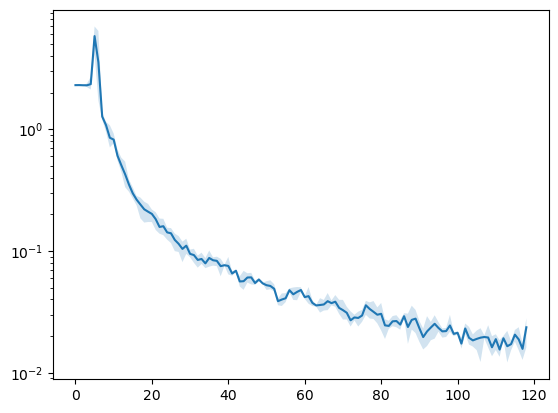

In [146]:
train_loss = [dsw(x["train_hist"]["batch_loss"], 50) for x in all_res]

mean_line = np.mean(train_loss, axis=0)
max_line = np.max(train_loss, axis=0)
min_line = np.min(train_loss, axis=0)

x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])

plt.fill_between(x, max_line, min_line, alpha=0.2) 
plt.semilogy(x, mean_line)

# plt.ylim(bottom=0.9, top=1.0)